In [1]:
# !pip install pillow==9.5.0
# !pip install trdg

In [2]:
import re
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

from datasets import load_dataset
from pythainlp.tokenize import sent_tokenize
from trdg.generators import GeneratorFromStrings

plt.rcParams['font.family'] = 'tahoma'

c:\Users\Admin\anaconda3\envs\dsai\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Missing modules for handwritten text generation.


In [3]:
# Load the Nov-1-2023 Thai Wikipedia dump
wiki = load_dataset("wikimedia/wikipedia", "20231101.th", split="train")  # :contentReference[oaicite:0]{index=0}

In [4]:
# Create dictionaries corpus of sentences
os.makedirs("dicts", exist_ok=True)

num_samps = 0
max_samps = 200000
stop_sampling = False

with open("dicts/th.txt", "w", encoding="utf-8") as f:
    for article in wiki:
        for sent in sent_tokenize(article["text"], engine="whitespace+newline"):
            if num_samps >= max_samps:
                stop_sampling = True
                break
            raw = sent.strip()
            # 1) remove any character not in ก-๛, A–Z, a–z, 0–9 or whitespace
            cleaned = re.sub(r"[^ก-๛A-Za-z0-9\s]", "", raw)
            # 2) collapse multiple spaces to one, trim
            cleaned = re.sub(r"\s+", " ", cleaned).strip()

            # only keep “long enough” sentences
            if len(cleaned) > 10:
                f.write(cleaned + "\n")
                num_samps += 1
        if stop_sampling:
            break

In [5]:
# Load Thai corpus
thai_corpus = open("dicts/th.txt", encoding="utf-8").read().splitlines()
thai_corpus[:10]

['ศาลาประชาคม',
 'ทรัพยากรและกิจกรรมซึ่งครอบคลุมวิกิพีเดียอย่างกว้างขวาง',
 'แผนกช่วยเหลือ',
 'ถามข้อสงสัยเกี่ยวกับการใช้งานวิกิพีเดีย',
 'ปุจฉาวิสัชนา',
 'ถามข้อสงสัยทั่วไปที่คุณอยากรู้',
 'บทความและข้อมูลข่าวเกี่ยวกับวิกิพีเดียและมูลนิธิวิกิมีเดีย',
 'สำหรับอภิปรายเกี่ยวกับวิกิพีเดีย',
 'รวมถึงรายงานปัญหาเทคนิคและเสนอนโยบาย',
 'Wikipediarelated']

In [6]:
thai_fonts = []

for root, dirs, files in os.walk(os.path.abspath("./fonts/th/")):
    for file in files:
        thai_fonts.append(os.path.join(root, file))

thai_fonts

['d:\\Python Scripts\\AIT\\AI Brain Lab\\Thai-Text-Recognizer-Dataset-Generation\\fonts\\th\\BaiJamjuree-Bold.ttf',
 'd:\\Python Scripts\\AIT\\AI Brain Lab\\Thai-Text-Recognizer-Dataset-Generation\\fonts\\th\\BaiJamjuree-Italic.ttf',
 'd:\\Python Scripts\\AIT\\AI Brain Lab\\Thai-Text-Recognizer-Dataset-Generation\\fonts\\th\\BaiJamjuree-Regular.ttf',
 'd:\\Python Scripts\\AIT\\AI Brain Lab\\Thai-Text-Recognizer-Dataset-Generation\\fonts\\th\\ChakraPetch-Bold.ttf',
 'd:\\Python Scripts\\AIT\\AI Brain Lab\\Thai-Text-Recognizer-Dataset-Generation\\fonts\\th\\ChakraPetch-Italic.ttf',
 'd:\\Python Scripts\\AIT\\AI Brain Lab\\Thai-Text-Recognizer-Dataset-Generation\\fonts\\th\\ChakraPetch-Regular.ttf',
 'd:\\Python Scripts\\AIT\\AI Brain Lab\\Thai-Text-Recognizer-Dataset-Generation\\fonts\\th\\Kanit-Bold.ttf',
 'd:\\Python Scripts\\AIT\\AI Brain Lab\\Thai-Text-Recognizer-Dataset-Generation\\fonts\\th\\Kanit-Italic.ttf',
 'd:\\Python Scripts\\AIT\\AI Brain Lab\\Thai-Text-Recognizer-Dataset-Ge

In [7]:
# Set up generator: here 5000 samples, font_dir, random skew/blur
gen = GeneratorFromStrings(
    thai_corpus,
    count=50000,
    fonts=thai_fonts,
    size=64,
    random_skew=True,
    skewing_angle=5,
    random_blur=True,
    blur=2
)

In [8]:
root = "ThaiOCR-Synth"
img_folder = os.path.join(root, "train")
os.makedirs(img_folder, exist_ok=True)
gt_path = os.path.join(root, "gt.txt")

In [9]:
# Generate dataset
with open(gt_path, "w", encoding="utf-8") as gt:
    for idx, (img, text) in enumerate(gen, start=1):
        img_name = f"word_{idx}.png"
        rel_path = f"train/{img_name}"
        # save image
        img.save(os.path.join(root, rel_path))
        # write line: test/word_i.png<TAB>label
        gt.write(f"{rel_path}\t{text}\n")

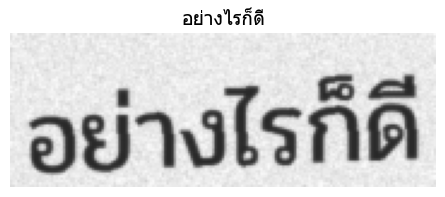

In [10]:
with open(gt_path, "r", encoding="utf-8") as f:
    lines = [l.strip() for l in f if l.strip()]

# Pick one random sample and display
sample = random.choice(lines)
img_rel, label = sample.split("\t", 1)
img_path = os.path.join(root, img_rel)

img = Image.open(img_path)
plt.figure(figsize=(6,2))
plt.imshow(img)
plt.axis("off")
plt.title(label, fontsize=14)
plt.show()